## DETECT ARTIFACT Z-SCORE INTRAVOLUME WITH ADAPTATIVE THRESHOLD USING INTRA-CROSS VOLUME INFO

In [1]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.stats import zscore
import glob
import matplotlib.pyplot as plt

In [2]:
def load_fmri_data(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

def compute_intravolume_scores(data):
    """For each volume, compute max z-score of slice-to-slice diff."""
    scores = []
    for v in range(data.shape[3]):
        vol = data[..., v]
        slice_means = vol.mean(axis=(0, 1))  # mean per axial slice
        diffs = np.abs(np.diff(slice_means))
        z_diffs = zscore(diffs)
        scores.append(np.max(z_diffs))
    return np.array(scores)

def compute_crossvolume_scores(data):
    """Compute slice-wise temporal z-score consistency for each volume."""
    z_dim = data.shape[2]
    t_dim = data.shape[3]
    cross_scores = np.zeros(t_dim)
    
    for z in range(z_dim):
        time_series = data[:, :, z, :].mean(axis=(0, 1))  # shape: (t,)
        z_scores = zscore(time_series)
        cross_scores += np.abs(z_scores)  # accumulate deviation
    
    return cross_scores / z_dim  # average deviation per volume

def get_adaptive_threshold(file_paths, compute_scores, percentile=99.5):
    all_scores = []
    for f in file_paths:
        data = load_fmri_data(f)
        scores = compute_scores(data)
        all_scores.extend(scores)
    threshold = np.percentile(all_scores, percentile)
    return threshold

In [3]:
# ---- RUNNING PIPELINE ----

folder_path = r'C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data'

# Collect paths
clean_paths = glob.glob(os.path.join(folder_path, "clean_*.nii.gz"))
artif_paths = glob.glob(os.path.join(folder_path, "artif_*.nii.gz"))
medium_paths = glob.glob(os.path.join(folder_path, "medium_*.nii.gz"))


In [4]:
# 1) Adaptive threshold learning
# adaptive_intra_thresh = get_adaptive_threshold(clean_paths, compute_intravolume_scores, percentile=99.5)
adaptive_intra_thresh = 3.94
print(f"Adaptive intravolume threshold from clean data: {adaptive_intra_thresh:.2f}")

# adaptive_cross_thresh = get_adaptive_threshold(clean_paths, compute_crossvolume_scores, percentile=99.5)
adaptive_cross_thresh = 2.01
print(f"Adaptive crossvolume threshold from clean data: {adaptive_cross_thresh:.2f}")

Adaptive intravolume threshold from clean data: 3.94
Adaptive crossvolume threshold from clean data: 2.01


In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def run_pipeline2(target_file, intra_thresh, cross_thresh, weight_intra, weight_cross, plot_stats=True, plot_artifacts=False, avg_good=3, save_csv=False):
    data = load_fmri_data(target_file)
    intra_scores = compute_intravolume_scores(data)
    cross_scores = compute_crossvolume_scores(data)

    # Combine both
    combined_scores = weight_intra * intra_scores + weight_cross * cross_scores
    # combined_scores = 1.0 * intra_scores + 1.0 * cross_scores
    
    # combined_threshold = weight_intra * intra_thresh + weight_cross * cross_thresh
    combined_threshold = 1.0 * intra_thresh + 1.0 * cross_thresh

    bad_volumes = np.where(combined_scores > combined_threshold)[0]    

    if save_csv:
        df = pd.DataFrame({
            "volume": np.arange(len(intra_scores)),
            "intra_volume_score": intra_scores,
            "cross_volume_score": cross_scores,
            "total_score": combined_scores,
            "is_artifact": combined_scores > combined_threshold,
        })
        
        df.to_csv(f"{os.path.basename(target_file).split('.')[0]}_artif_detect.csv", index=False)
    
    if plot_stats:
        plt.figure(figsize=(12, 5))
        plt.plot(combined_scores, label="Total Combined Score")
        plt.plot(intra_scores, label="IntraVolume Score", alpha=0.5)
        plt.plot(cross_scores, label="CrossVolume Score", alpha=0.5)
        plt.axhline(intra_thresh, color='green', linestyle='--', label=f'Adaptive intra Threshold={intra_thresh:.2f}')
        plt.axhline(cross_thresh, color='orange', linestyle='--', label=f'Adaptive cross Threshold={cross_thresh:.2f}')
        plt.axhline(combined_threshold, color='red', linestyle='--', label=f'Combined Threshold={combined_threshold:.2f}')
        # for volume in bad_volumes:
        #     plt.axvline(volume, color='purple', linestyle='--', label='')
        # plt.xlabel("Volume Index")
        plt.ylabel("Score")
        plt.title("Artifact Detection: Combined Temporal & Spatial Metric")
        plt.legend()
        plt.tight_layout()
        plt.show()

    print("Detected artifact volumes:", bad_volumes.tolist())
    
    if plot_artifacts:
    
        vmin, vmax = np.percentile(data, (10, 97.5))
        
        color_map = 'viridis'
        
        # Plot axial, sagittal, and coronal cuts for each bad volume
        for volume in bad_volumes:
            # Find the previous and next good volumes
            prev_good_volume = next((v for v in range(volume - 1, -1, -1) if v not in bad_volumes), None)
            next_good_volume = next((v for v in range(volume + 1, data.shape[3]) if v not in bad_volumes), None)

            # Identify the slice with the maximum artifact score for the bad volume
            vol = data[..., volume]
            slice_means = vol.mean(axis=(0, 1))  # mean per axial slice
            diffs = np.abs(np.diff(slice_means))  # differences between slices
            artifact_slice_idx = np.argmax(diffs)  # slice with the maximum artifact
            
            # Find the avg_good previous and avg_good next good volumes
            prev_good_volumes = []
            next_good_volumes = []
            # Search backwards for previous good volumes
            v = volume - 1
            while v >= 0 and len(prev_good_volumes) < avg_good:
                if v not in bad_volumes:
                    prev_good_volumes.append(v)
                v -= 1
            # Search forwards for next good volumes
            v = volume + 1
            while v < data.shape[3] and len(next_good_volumes) < avg_good:
                if v not in bad_volumes:
                    next_good_volumes.append(v)
                v += 1

            # Only proceed if we have enough good volumes on both sides
            if len(prev_good_volumes) == 3 and len(next_good_volumes) == 3:
                good_volumes = prev_good_volumes + next_good_volumes
                # Compute mean of good volumes for each orientation
                coronal_good = np.mean([data[:, artifact_slice_idx, :, gv] for gv in good_volumes], axis=0)
                sagittal_good = np.mean([data[artifact_slice_idx, :, :, gv] for gv in good_volumes], axis=0)
                axial_good = np.mean([data[:, :, artifact_slice_idx, gv] for gv in good_volumes], axis=0)

            # # Only proceed if both good volumes exist
            # if prev_good_volume is not None and next_good_volume is not None:
            #     # Compute mean of previous and next good volumes for each orientation
            #     coronal_good = 0.5 * (data[:, artifact_slice_idx, :, prev_good_volume] + data[:, artifact_slice_idx, :, next_good_volume])
            #     sagittal_good = 0.5 * (data[artifact_slice_idx, :, :, prev_good_volume] + data[artifact_slice_idx, :, :, next_good_volume])
            #     axial_good = 0.5 * (data[:, :, artifact_slice_idx, prev_good_volume] + data[:, :, artifact_slice_idx, next_good_volume])

                # Artifact slices
                coronal_bad = data[:, artifact_slice_idx, :, volume]
                sagittal_bad = data[artifact_slice_idx, :, :, volume]
                axial_bad = data[:, :, artifact_slice_idx, volume]

                # Differences
                coronal_diff = np.abs(coronal_bad - coronal_good)
                sagittal_diff = np.abs(sagittal_bad - sagittal_good)
                axial_diff = np.abs(axial_bad - axial_good)

                fig, axes = plt.subplots(3, 3, figsize=(15, 15))

                # Good, Bad, Difference for Coronal
                axes[0, 0].imshow(coronal_good.T, cmap=color_map, origin='lower', vmin=vmin, vmax=vmax)
                axes[0, 0].set_title('Coronal (Avg Good)')
                axes[0, 1].imshow(coronal_bad.T, cmap=color_map, origin='lower', vmin=vmin, vmax=vmax)
                axes[0, 1].set_title(f'Coronal (Bad Vol {volume})')
                axes[0, 2].imshow(coronal_diff.T, cmap='hot', origin='lower')
                axes[0, 2].set_title('Coronal |Difference|')
                # add colorbar for difference
                # Make colorbar same height as the plot
                divider = make_axes_locatable(axes[0, 2])
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(axes[0, 2].images[0], cax=cax)

                # Good, Bad, Difference for Sagittal
                axes[1, 0].imshow(sagittal_good.T, cmap=color_map, origin='lower', vmin=vmin, vmax=vmax)
                axes[1, 0].set_title('Sagittal (Avg Good)')
                axes[1, 1].imshow(sagittal_bad.T, cmap=color_map, origin='lower', vmin=vmin, vmax=vmax)
                axes[1, 1].set_title(f'Sagittal (Bad Vol {volume})')
                axes[1, 2].imshow(sagittal_diff.T, cmap='hot', origin='lower')
                axes[1, 2].set_title('Sagittal |Difference|')
                # add colorbar for difference
                divider = make_axes_locatable(axes[1, 2])
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(axes[1, 2].images[0], cax=cax)

                # Good, Bad, Difference for Axial
                axes[2, 0].imshow(axial_good.T, cmap=color_map, origin='lower', vmin=vmin, vmax=vmax)
                axes[2, 0].set_title('Axial (Avg Good)')
                axes[2, 1].imshow(axial_bad.T, cmap=color_map, origin='lower', vmin=vmin, vmax=vmax)
                axes[2, 1].set_title(f'Axial (Bad Vol {volume})')
                axes[2, 2].imshow(axial_diff.T, cmap='hot', origin='lower')
                axes[2, 2].set_title('Axial |Difference|')
                # add colorbar for difference
                divider = make_axes_locatable(axes[2, 2])
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(axes[2, 2].images[0], cax=cax)

            plt.tight_layout()
            plt.show()

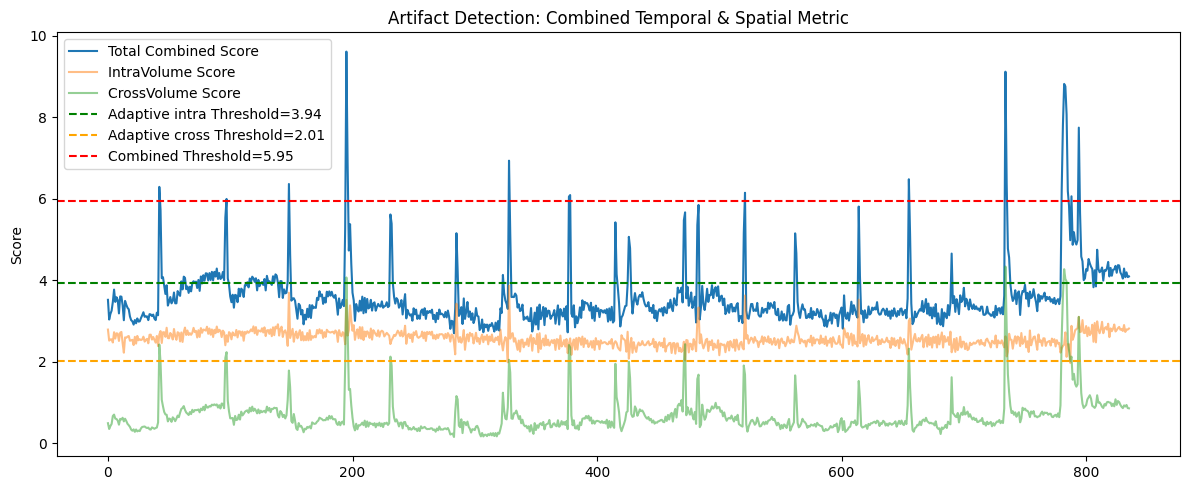

Detected artifact volumes: [42, 97, 148, 195, 196, 328, 377, 378, 521, 655, 734, 735, 780, 781, 782, 783, 784, 785, 788, 794]


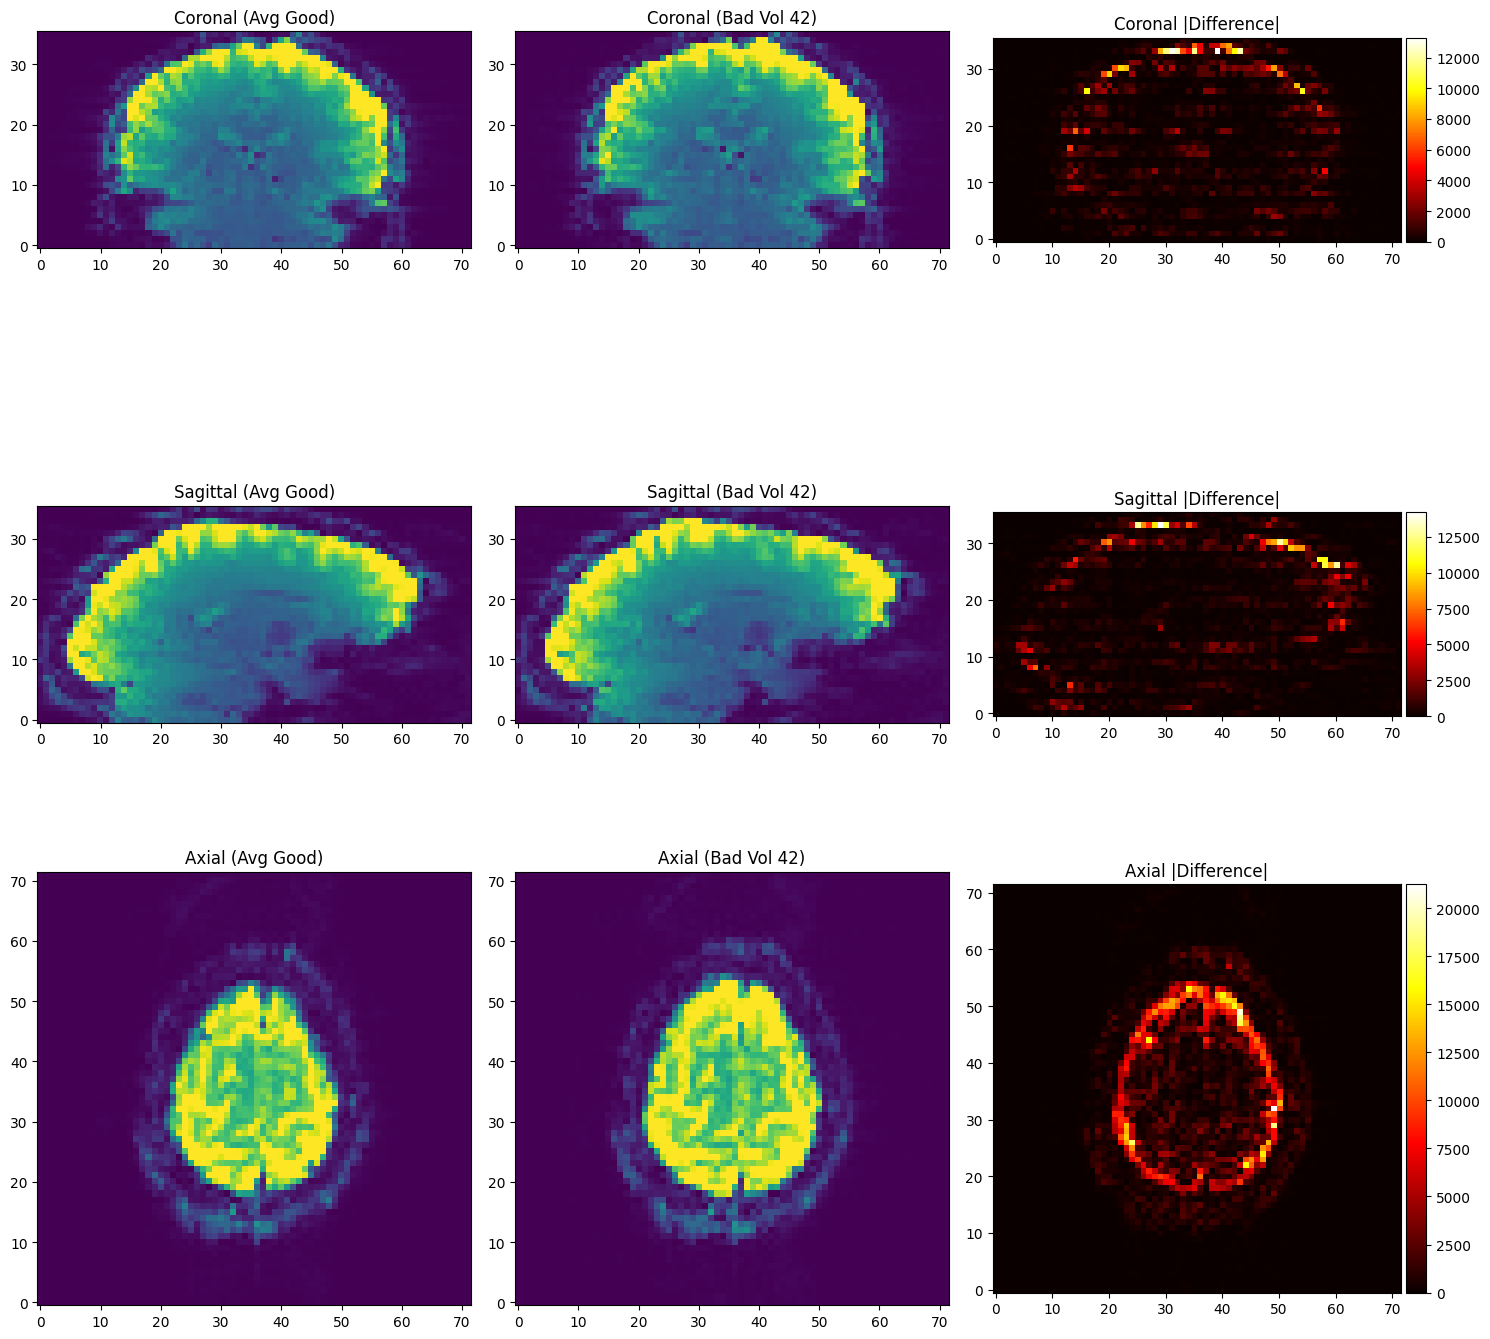

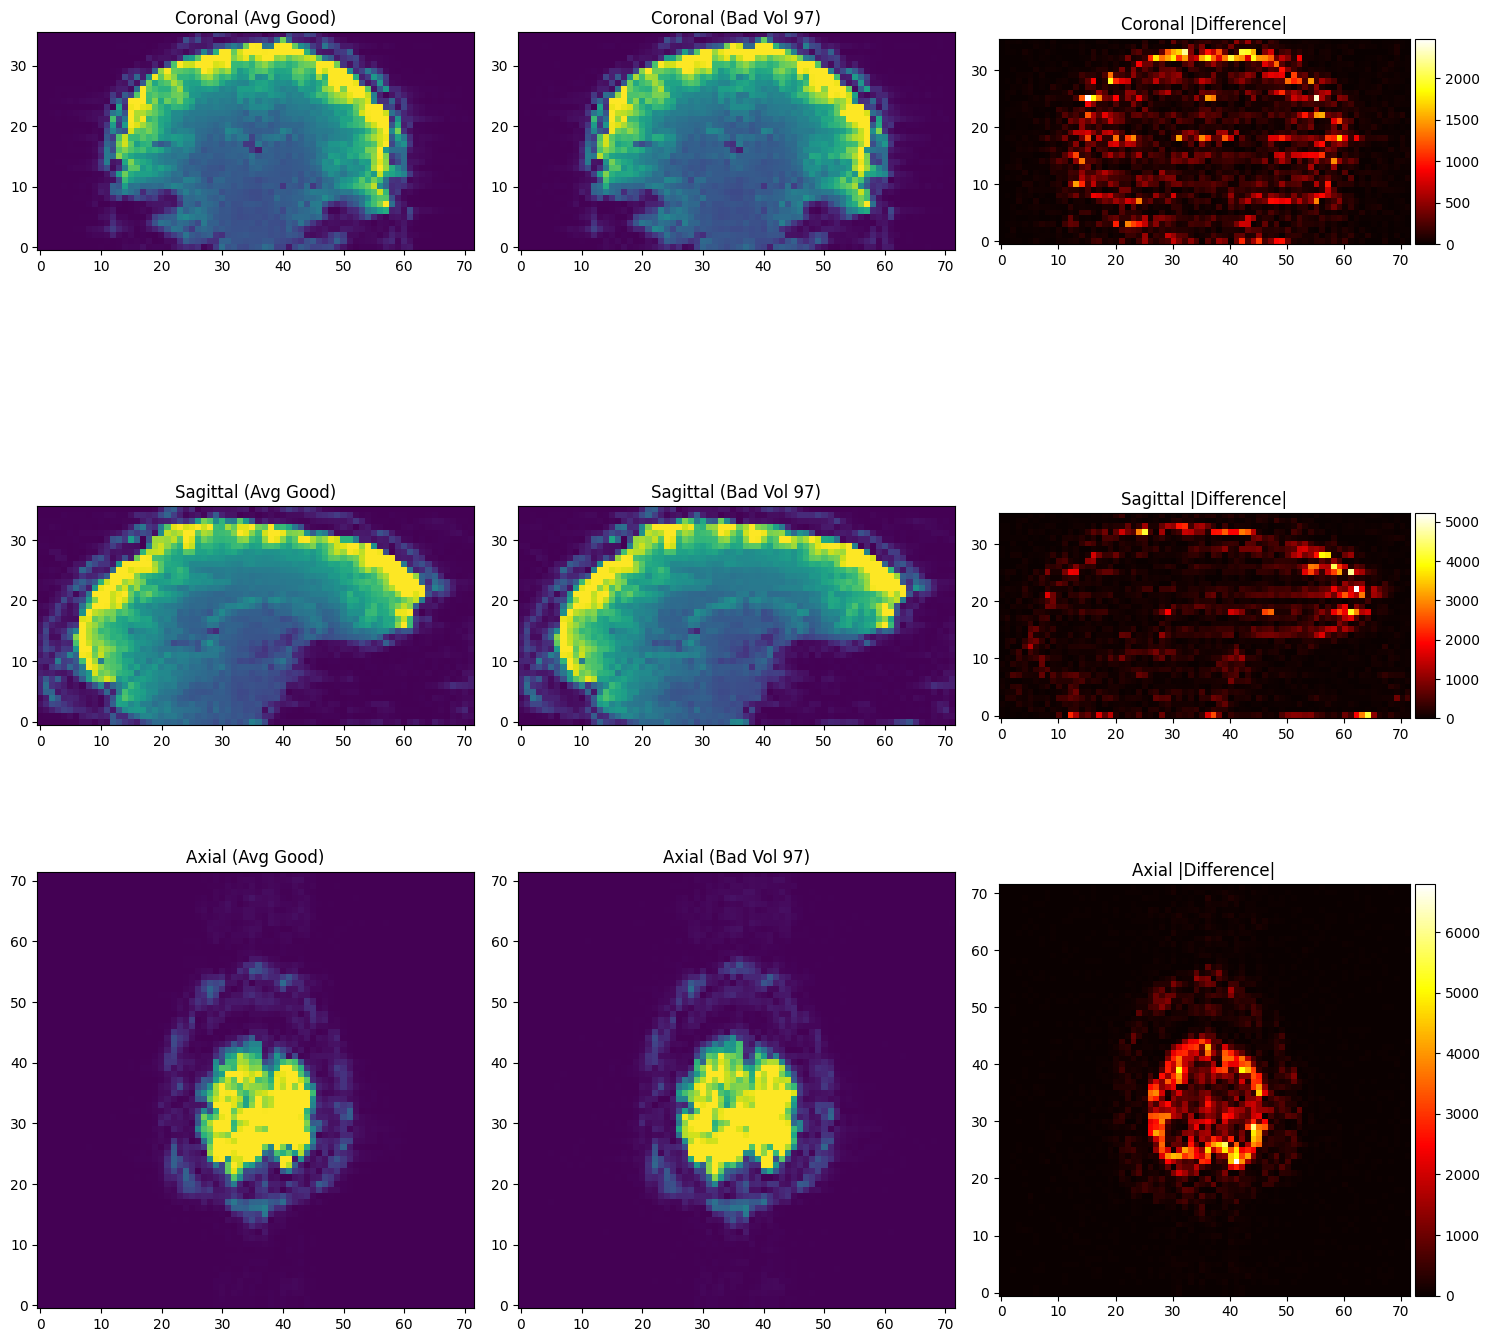

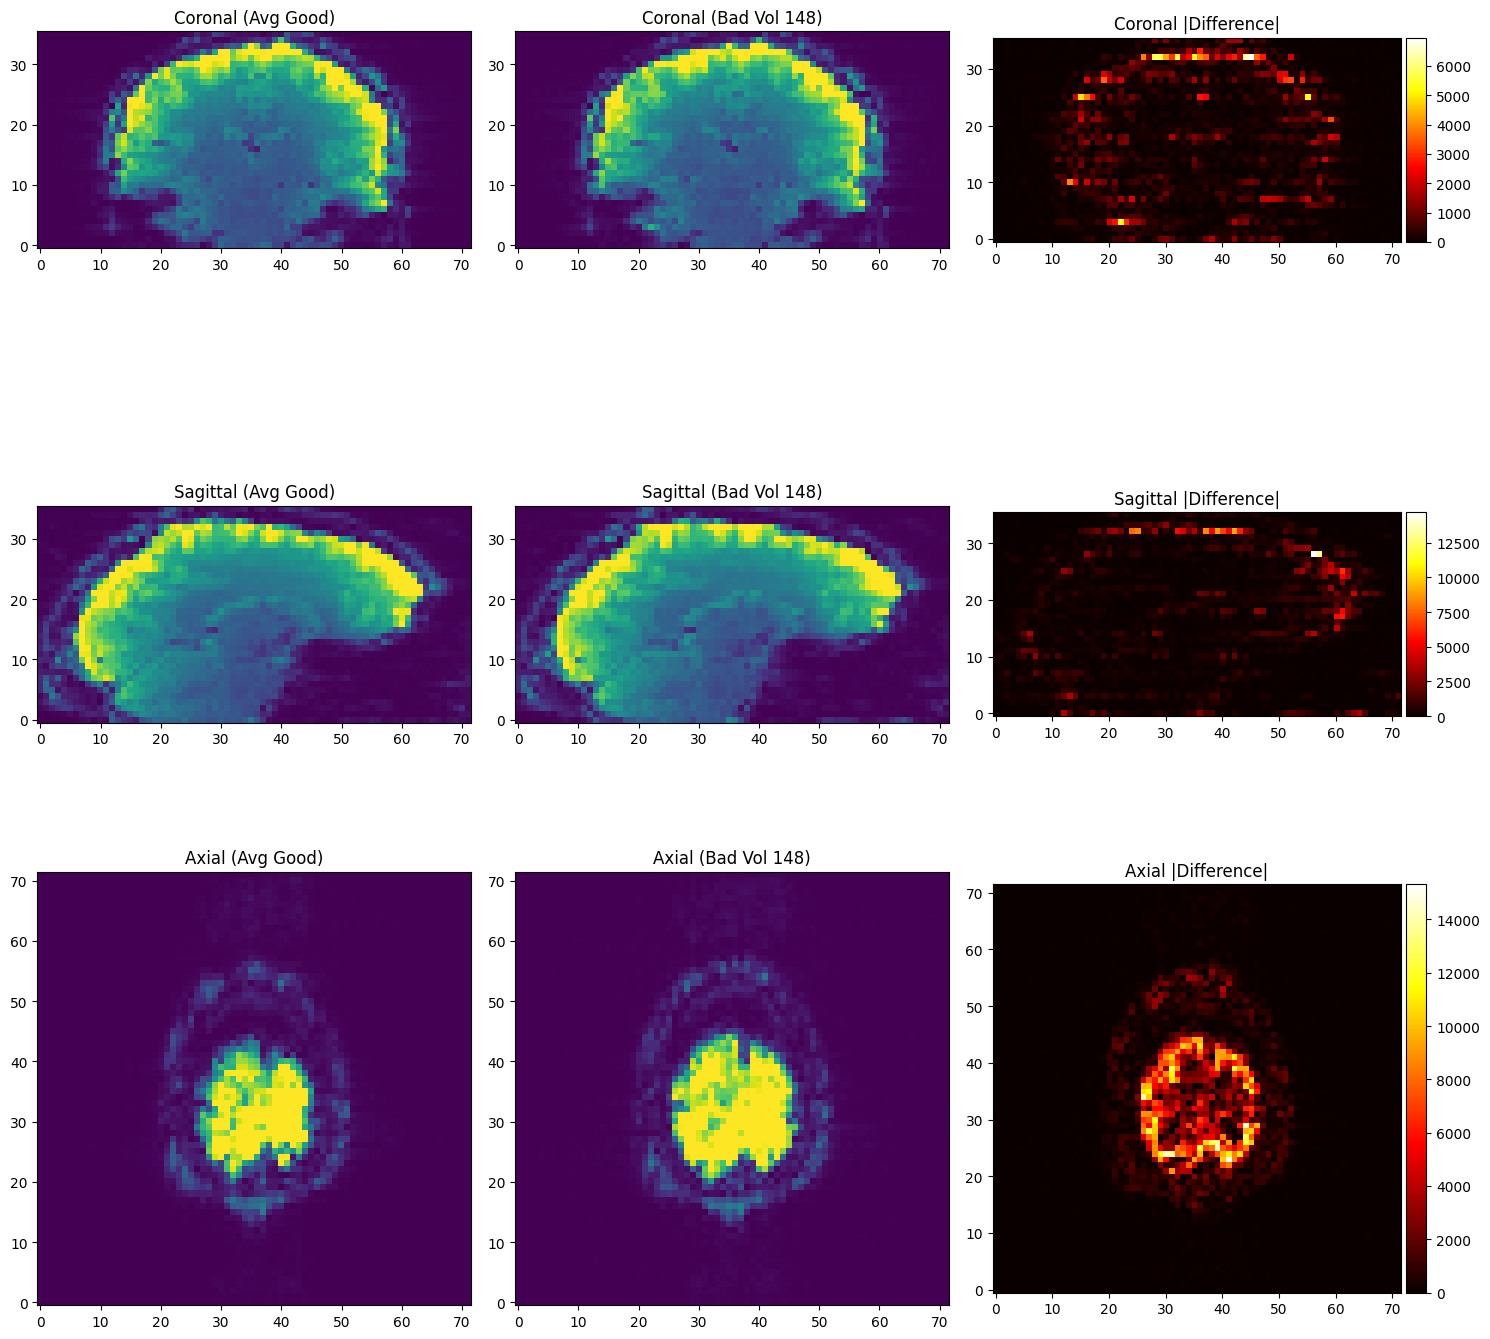

KeyboardInterrupt: 

In [15]:
file_path = r'C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\artif_01_bold.nii.gz'
run_pipeline2(file_path, adaptive_intra_thresh, adaptive_cross_thresh, 
              weight_intra=1.0, weight_cross=1.5, 
              plot_stats=True,
              plot_artifacts=True, avg_good=3, 
              save_csv=True)

Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\artif_01_bold.nii.gz...


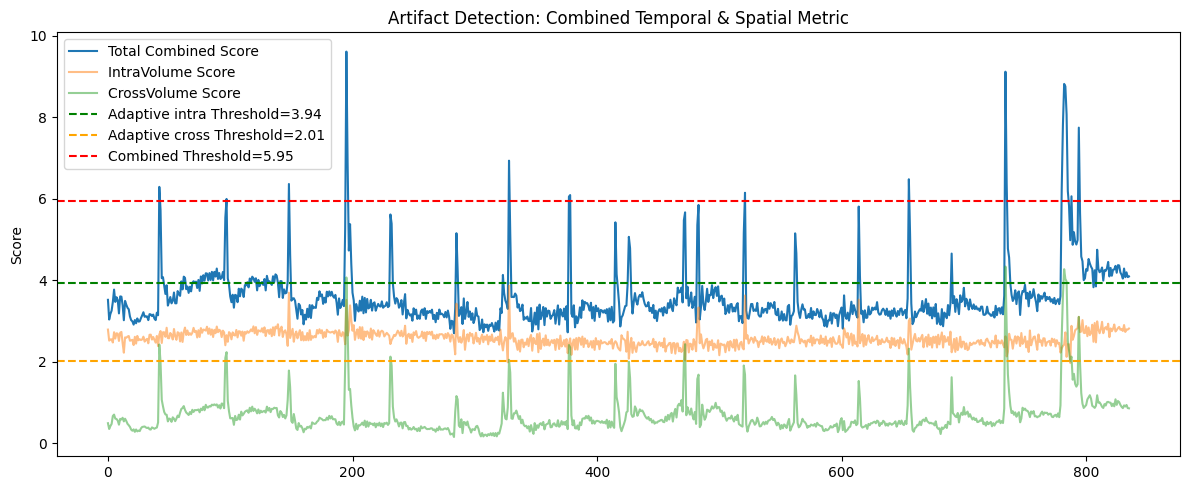

Detected artifact volumes: [42, 97, 148, 195, 196, 328, 377, 378, 521, 655, 734, 735, 780, 781, 782, 783, 784, 785, 788, 794]
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\artif_02_bold.nii.gz...


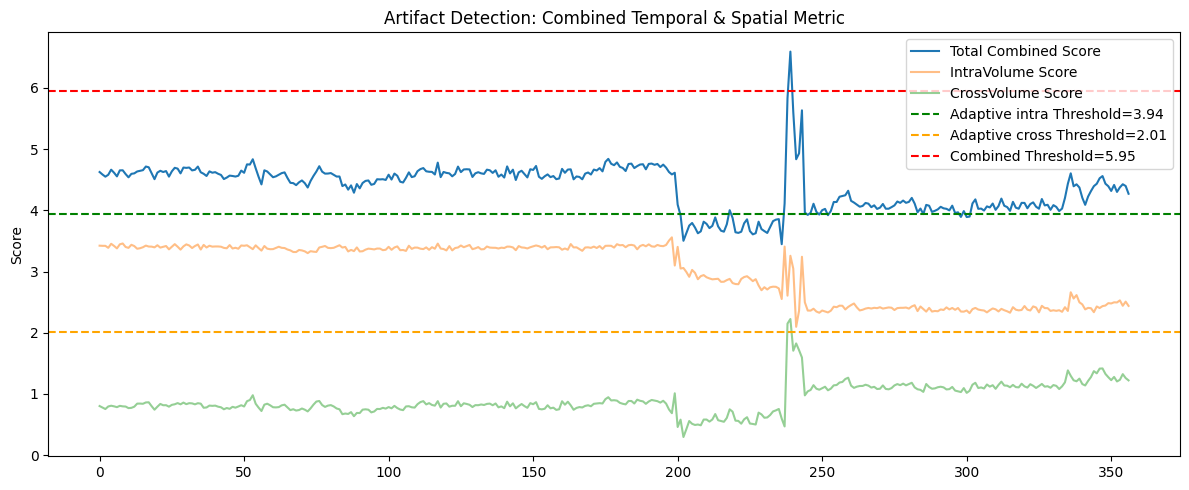

Detected artifact volumes: [239]
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\artif_03_bold.nii.gz...


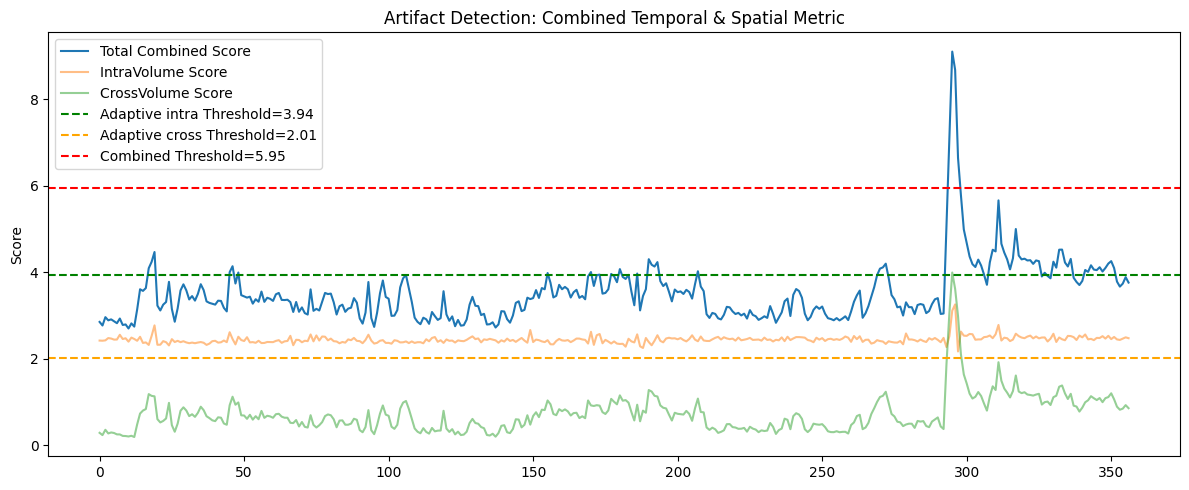

Detected artifact volumes: [294, 295, 296, 297]
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\artif_04_bold.nii.gz...


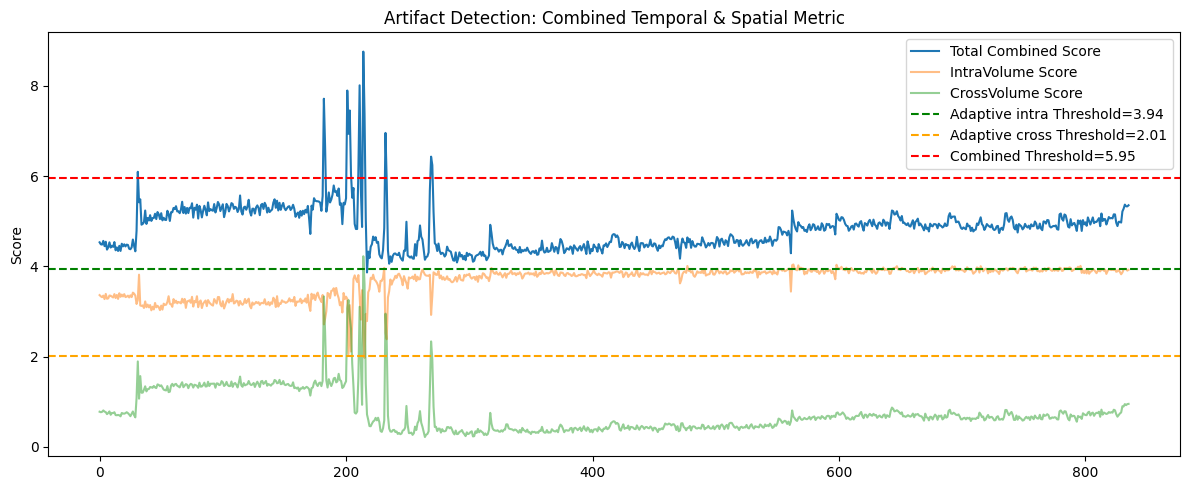

Detected artifact volumes: [31, 182, 183, 201, 202, 203, 204, 210, 211, 214, 215, 232, 269, 270]
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\artif_05_bold.nii.gz...


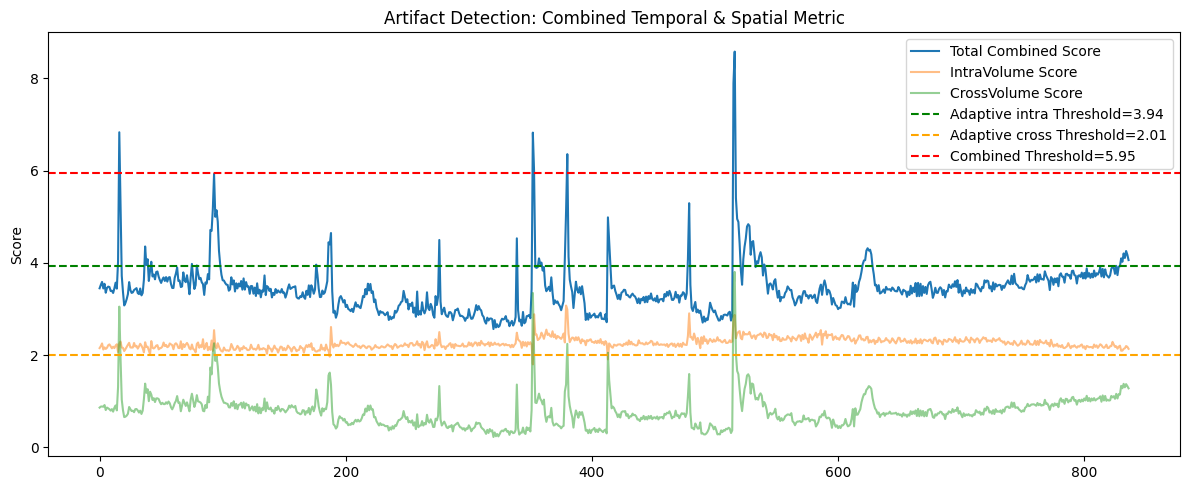

Detected artifact volumes: [16, 352, 353, 380, 515, 516]
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\clean_01_bold.nii.gz...


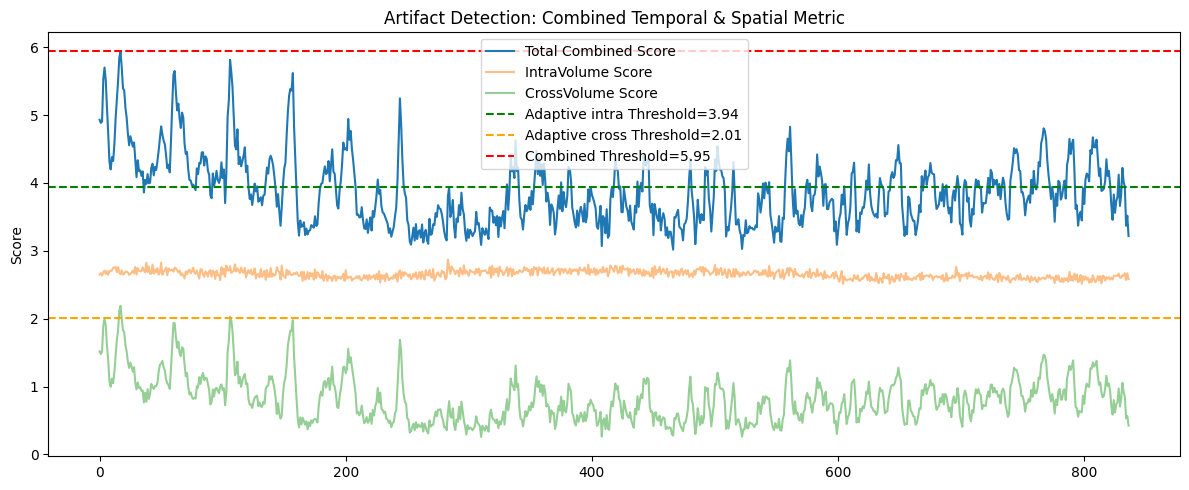

Detected artifact volumes: []
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\clean_02_bold.nii.gz...


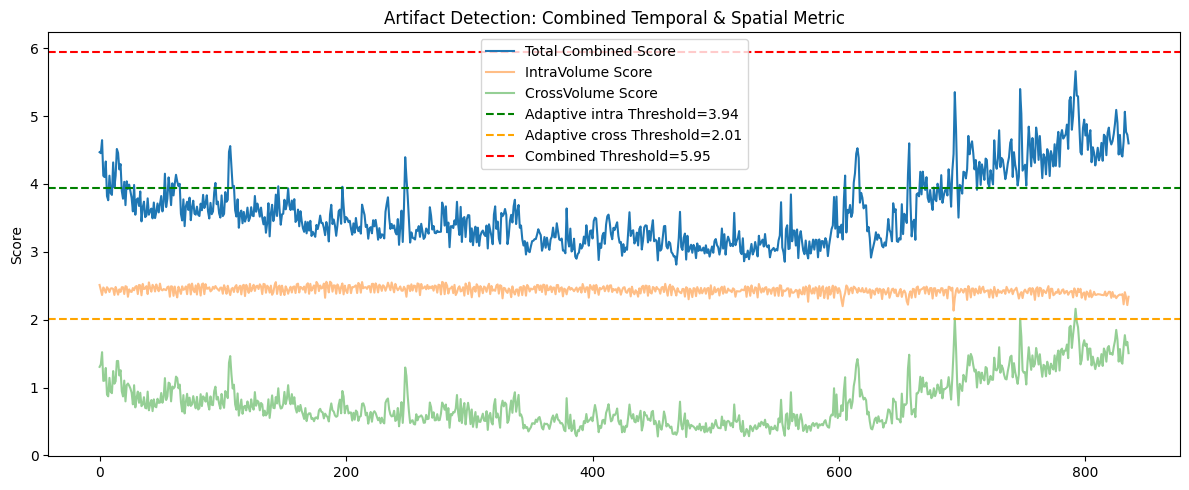

Detected artifact volumes: []
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\clean_03_bold.nii.gz...


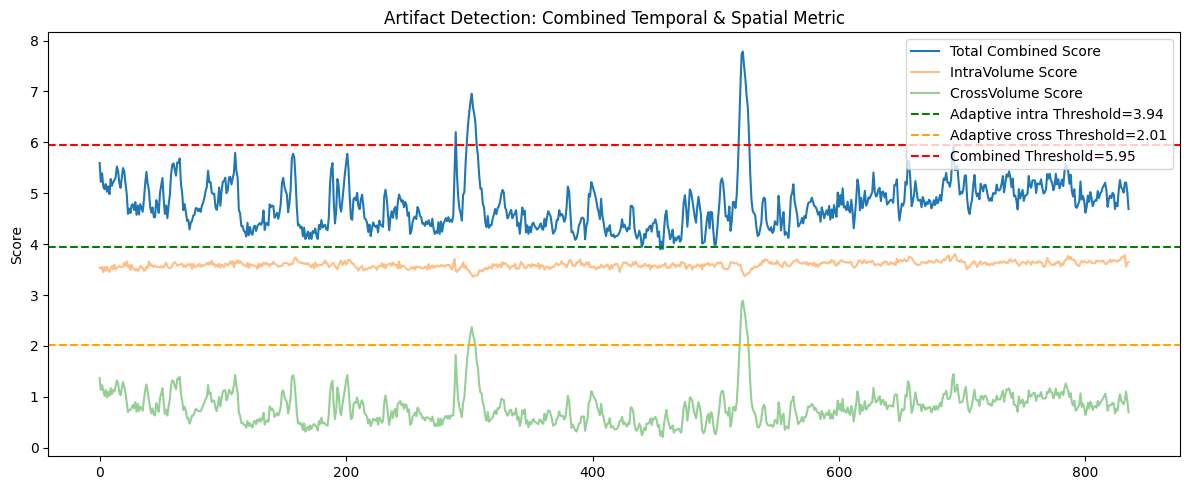

Detected artifact volumes: [289, 298, 299, 300, 301, 302, 303, 304, 305, 519, 520, 521, 522, 523, 524, 525, 526, 527]
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\clean_04_bold.nii.gz...


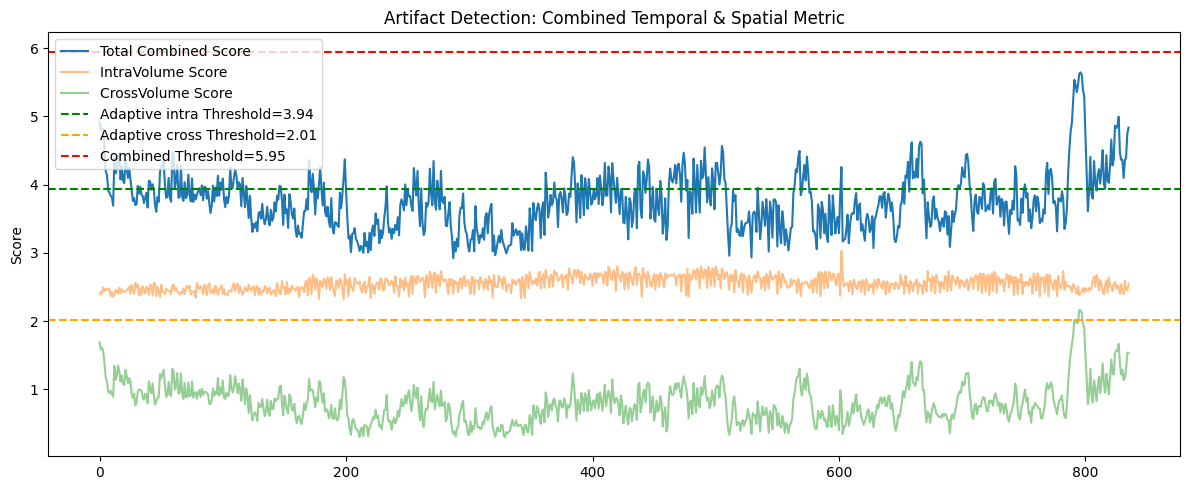

Detected artifact volumes: []
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\clean_05_bold.nii.gz...


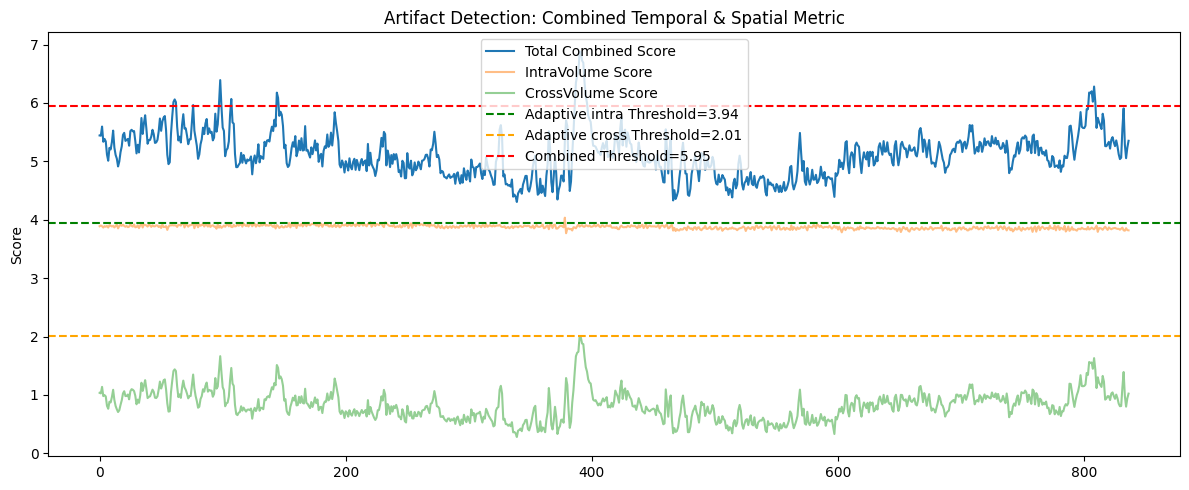

Detected artifact volumes: [60, 61, 62, 76, 97, 98, 107, 144, 145, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 804, 805, 806, 807, 808, 809]
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\medium_01_bold.nii.gz...


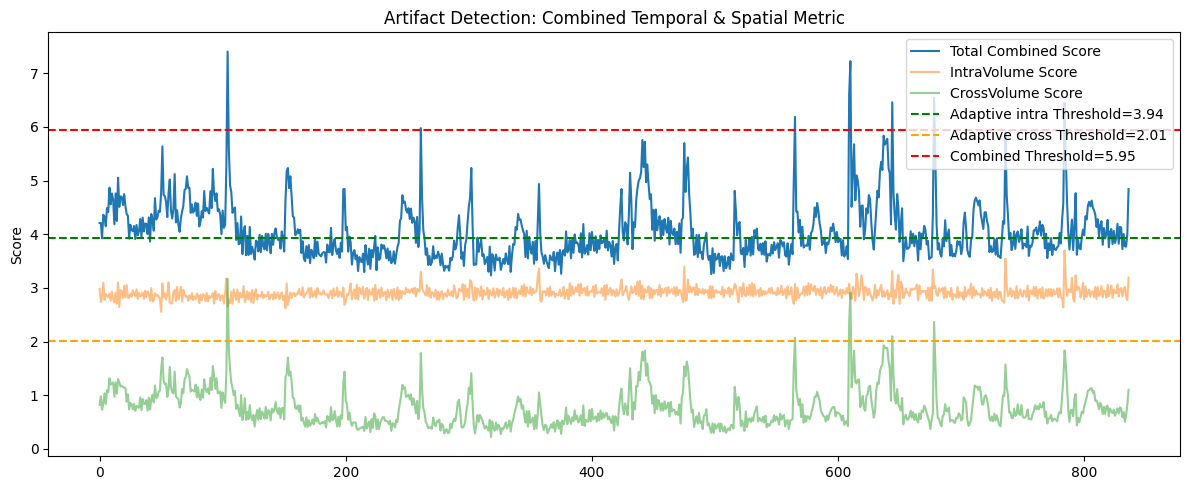

Detected artifact volumes: [104, 261, 565, 609, 610, 644, 678, 784]
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\medium_02_bold.nii.gz...


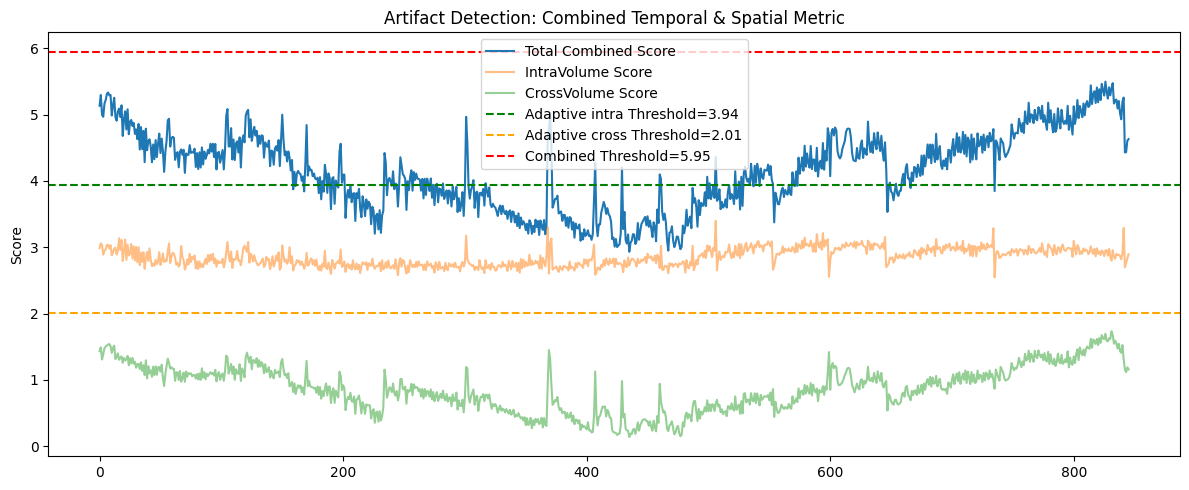

Detected artifact volumes: []
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\medium_03_bold.nii.gz...


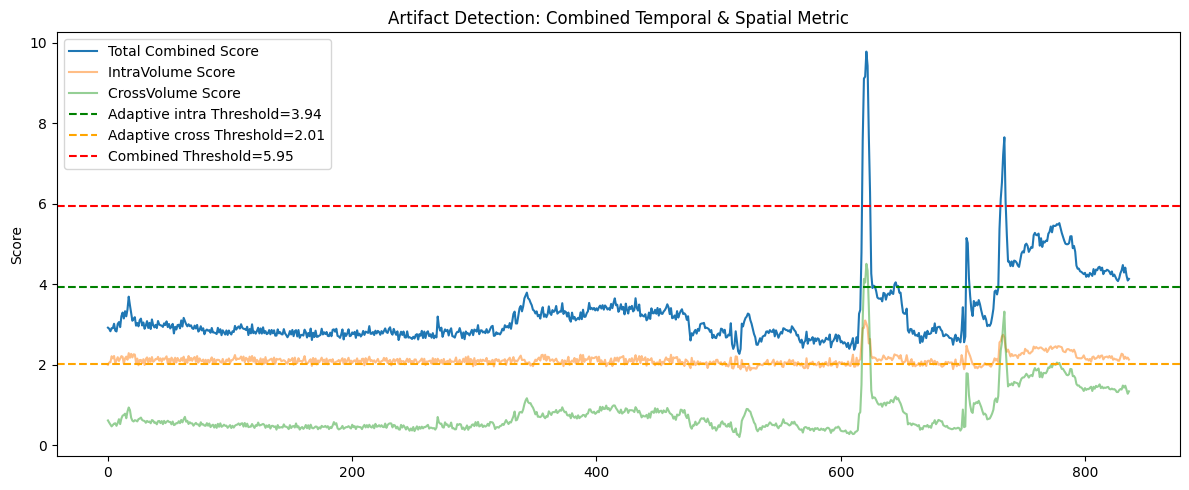

Detected artifact volumes: [618, 619, 620, 621, 622, 623, 624, 731, 732, 733, 734, 735]
Processing C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\medium_04_bold.nii.gz...


KeyboardInterrupt: 

In [ ]:
folder_path = r'C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data'

# List all .nii.gz files in the folder
nii_files = [f for f in os.listdir(folder_path) if f.endswith('.nii.gz')]

# Process each file
for idx, file in enumerate(nii_files):
    file_path = os.path.join(folder_path, file)
    print(f"Processing {file_path}...")
    run_pipeline2(file_path, adaptive_intra_thresh, adaptive_cross_thresh, 
                weight_intra=1.0, weight_cross=1.5, 
                plot_stats=True,
                plot_artifacts=False, avg_good=3, 
                save_csv=False)
        
    if idx >= 2:
        break